# import modules

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# light blue and orange
correct_color = "tab:blue"
incorrect_color = "tab:orange"

# define functions

In [49]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

def preprocess_df(raw_df:pd.DataFrame, true_label:pd.DataFrame)->pd.DataFrame:
    df = raw_df.copy()
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    min_max_func = lambda x: (x - x.min()) / (x.max() - x.min()) # min-max normalization
    convert_probability_func = lambda x: x / x.sum() # convert to binary
    processed_df = df.apply(min_max_func, axis=1).apply(convert_probability_func, axis=1)
    processed_df.columns = LABELS
    processed_df["predict_probability"] = processed_df.max(axis=1)
    processed_df["predict_label"] = processed_df.idxmax(axis=1)
    processed_df['true_label'] = true_label.map(lambda x: LABELS[x])
    return processed_df

def show_count(processed_df, title):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.ylim(0,400)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    plt.savefig(f'assets/{title}-count.png')
    plt.show()

def show_count_stacked(processed_df, title, split_size=0.01):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df = df.loc[:,['incorrect', 'correct',]]
    correct_list = list()
    incorrect_list = list()
    split_num = int(1/split_size)
    for i in range(split_num,0,-1):
        i *= split_size
        correct_list.append((df.correct>i).sum())
        incorrect_list.append((df.incorrect>i).sum())
    correct_list.reverse()
    incorrect_list.reverse()
    plt.bar(np.arange(split_num)*split_size, incorrect_list, width=split_size, color=incorrect_color)
    plt.bar(np.arange(split_num)*split_size, correct_list, width=split_size, color=correct_color, bottom=incorrect_list)
    plt.title(f'{title}\nPredict Probability Stacked Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    plt.savefig(f'assets/{title}-count-stacked.png')
    plt.show()

def show_confusion_matrix(df, title):
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    cm = confusion_matrix(df['true_label'], df['predict_label'], labels=LABELS)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f'{title}\nConfusion Matrix\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig(f'assets/{title}-confusion-matrix.png')
    plt.show()

def calc_thredshold_df(df):
    thresholds = [i*0.1 for i in range(11)]
    acc_list = list()
    count_list = list()
    for threshold in thresholds:
        acc_list.append(calc_accuracy(df.loc[df.predict_probability>threshold]))
        count_list.append(len(df.loc[df.predict_probability>threshold]))
    threshold_df = pd.DataFrame({'threshold': thresholds, 'accuracy': acc_list, 'count': count_list})
    return threshold_df.set_index('threshold')

# load data

In [50]:
convbbt_layer3_raw_df = pd.read_csv('../convbbt-layer:3/predict.csv', index_col=0).drop(columns=["true"])
convbbt_layer5_raw_df = pd.read_csv('../convbbt/predict.csv', index_col=0).drop(columns=["true"])
convbbt_layer7_raw_df = pd.read_csv('../convbbt-layer:7/predict.csv', index_col=0).drop(columns=["true"])
true_label = pd.read_csv('../convbbt/predict.csv', index_col=0)["true"]

# check data

## raw data head

In [51]:
convbbt_layer3_raw_df.head()

,0,1,2,3,4,5
0,4.794195,-8.249228,-9.894946,-5.896336,0.786684,5.269970
1,-0.641768,-9.602808,14.231035,0.573691,0.052295,1.060287
2,2.612563,-11.385828,-12.903688,-0.402864,9.754886,0.731949
3,1.384545,17.906736,-4.959831,-6.789407,-3.877294,-2.255584
4,-4.220795,-6.356165,-3.674784,14.070560,-2.290916,3.999891


In [52]:
convbbt_layer5_raw_df.head()

,0,1,2,3,4,5
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


In [53]:
convbbt_layer7_raw_df.head()

,0,1,2,3,4,5
0,5.036437,-4.502230,-6.603404,-5.567816,-1.089012,7.162587
1,-3.746440,-7.409843,14.647223,1.599128,-0.146993,0.334431
2,1.839661,-10.998505,-6.005250,-5.750884,8.651728,2.211259
3,-1.004645,13.123766,-5.008782,-5.039395,-2.758281,-1.509961
4,-3.875755,-1.584597,4.366080,13.186352,-8.073782,4.969984


In [54]:
convbbt_layer3_df = preprocess_df(convbbt_layer3_raw_df, true_label)
convbbt_layer5_df = preprocess_df(convbbt_layer5_raw_df, true_label)
convbbt_layer7_df = preprocess_df(convbbt_layer7_raw_df, true_label)

## processed data head

In [55]:
convbbt_layer3_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.318084,0.035637,0.000000,0.086587,0.231304,0.328387,0.328387,Walking,Walking
1,0.141588,0.000000,0.376584,0.160793,0.152554,0.168481,0.376584,Sitting,Sitting
2,0.235705,0.023058,0.000000,0.189898,0.344203,0.207137,0.344203,Upstairs,Upstairs
3,0.193946,0.585972,0.043411,0.000000,0.069096,0.107575,0.585972,Jogging,Jogging
4,0.053835,0.000000,0.067601,0.514984,0.102490,0.261089,0.514984,Standing,Standing


In [56]:
convbbt_layer5_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.257560,0.083064,0.000000,0.053973,0.282588,0.322815,0.322815,Walking,Walking
1,0.039920,0.000000,0.490490,0.300848,0.113302,0.055439,0.490490,Sitting,Sitting
2,0.283220,0.000000,0.010029,0.084436,0.347397,0.274919,0.347397,Upstairs,Upstairs
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,Jogging,Jogging
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing


In [57]:
convbbt_layer7_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.341775,0.061696,0.000000,0.030407,0.161917,0.404205,0.404205,Walking,Walking
1,0.073656,0.000000,0.443478,0.181134,0.146026,0.155706,0.443478,Sitting,Sitting
2,0.229503,0.000000,0.089262,0.093810,0.351279,0.236146,0.351279,Upstairs,Upstairs
3,0.143897,0.647780,0.001092,0.000000,0.081355,0.125876,0.647780,Jogging,Jogging
4,0.073097,0.112991,0.216605,0.370186,0.000000,0.227121,0.370186,Standing,Standing


# Each Model

# frequency of each model

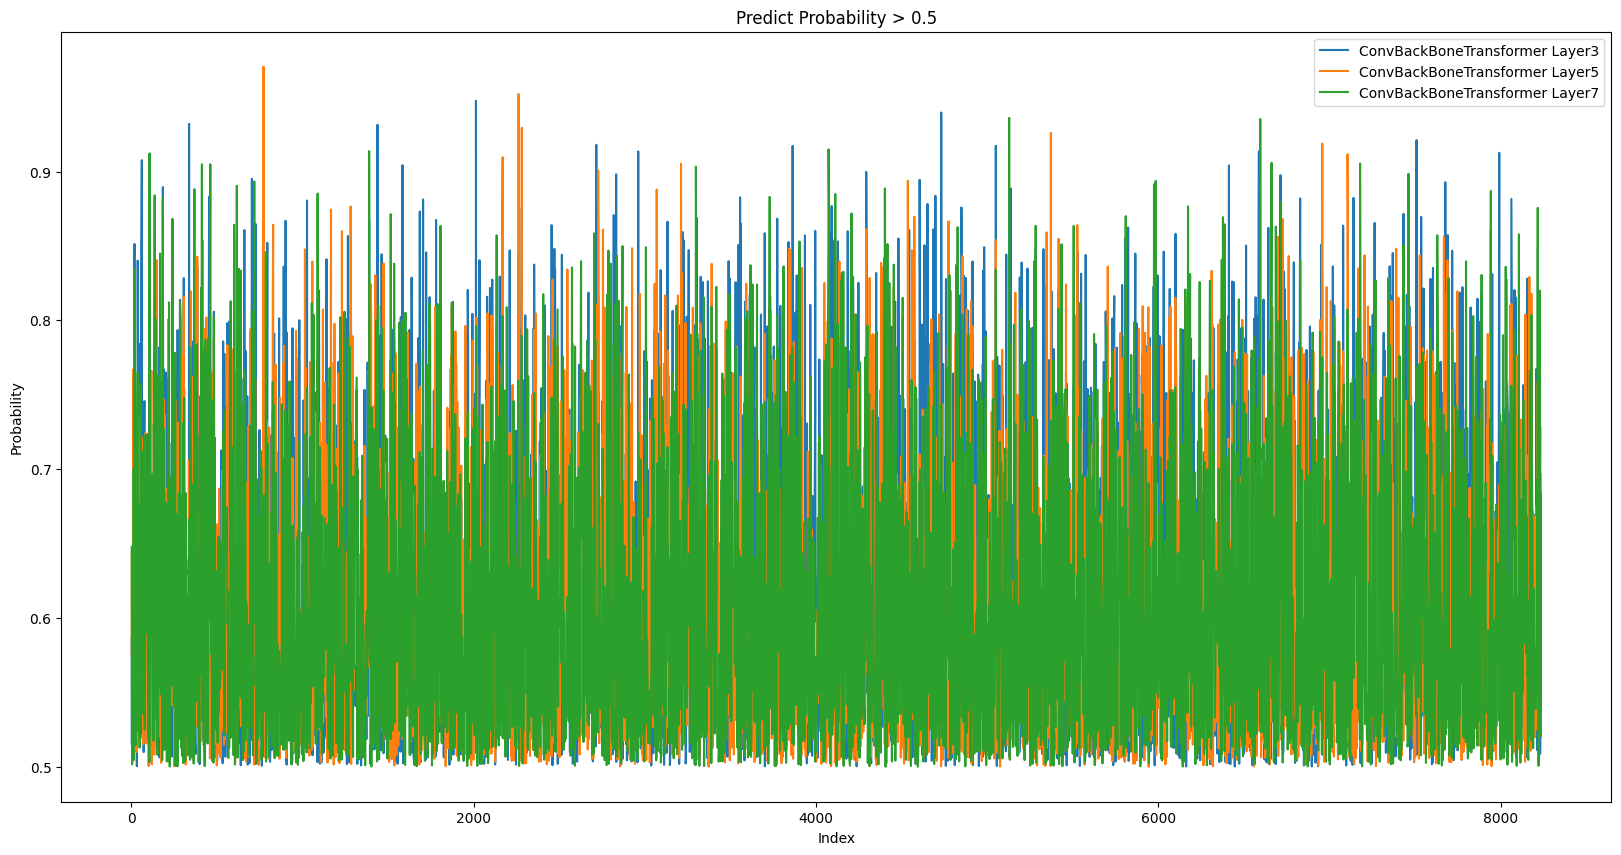

In [58]:
plt.rcParams['figure.figsize'] = [20, 10]
threshold = 0.5
convbbt_layer3_df.loc[convbbt_layer3_df.predict_probability>threshold,'predict_probability'].plot()
convbbt_layer5_df.loc[convbbt_layer5_df.predict_probability>threshold,'predict_probability'].plot()
convbbt_layer7_df.loc[convbbt_layer7_df.predict_probability>threshold,'predict_probability'].plot()
plt.title(f'Predict Probability > {threshold}')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend(['ConvBackBoneTransformer Layer3', 'ConvBackBoneTransformer Layer5', 'ConvBackBoneTransformer Layer7'])

## count

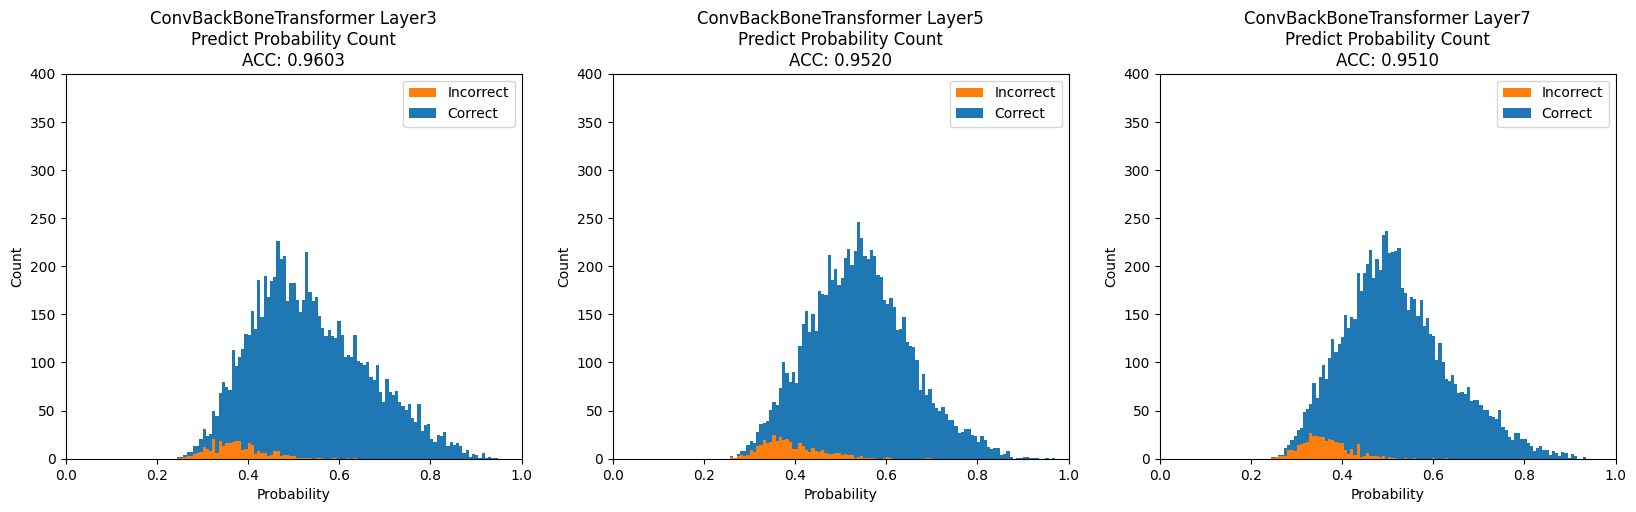

In [59]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 400)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']
# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

## Stacked Count

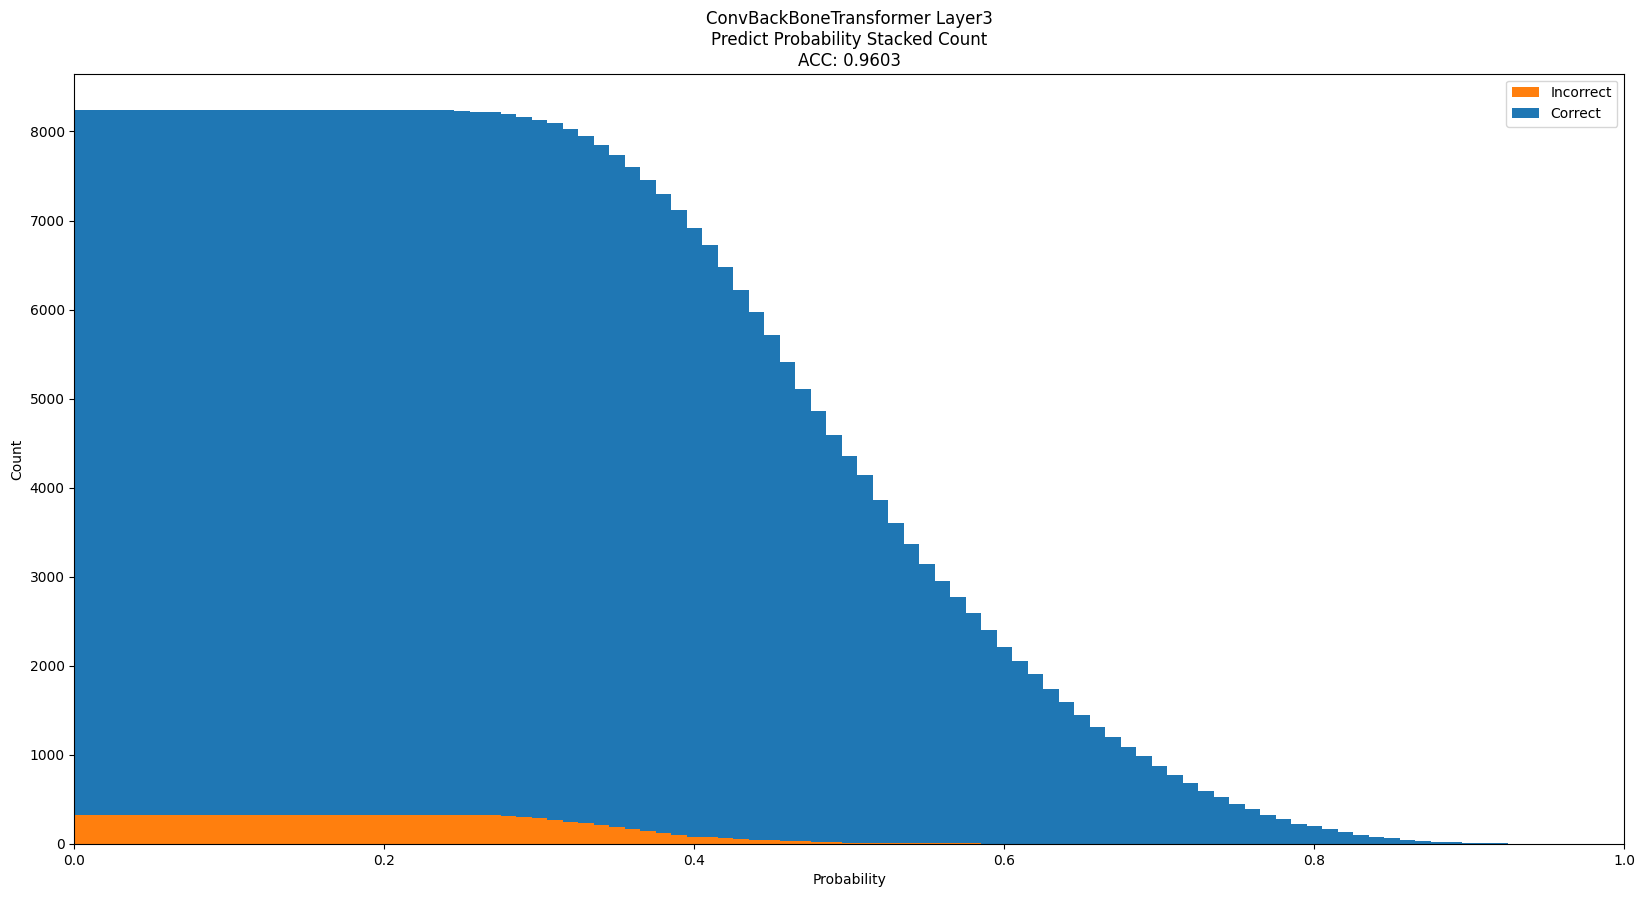

In [60]:
show_count_stacked(convbbt_layer3_df, 'ConvBackBoneTransformer Layer3')

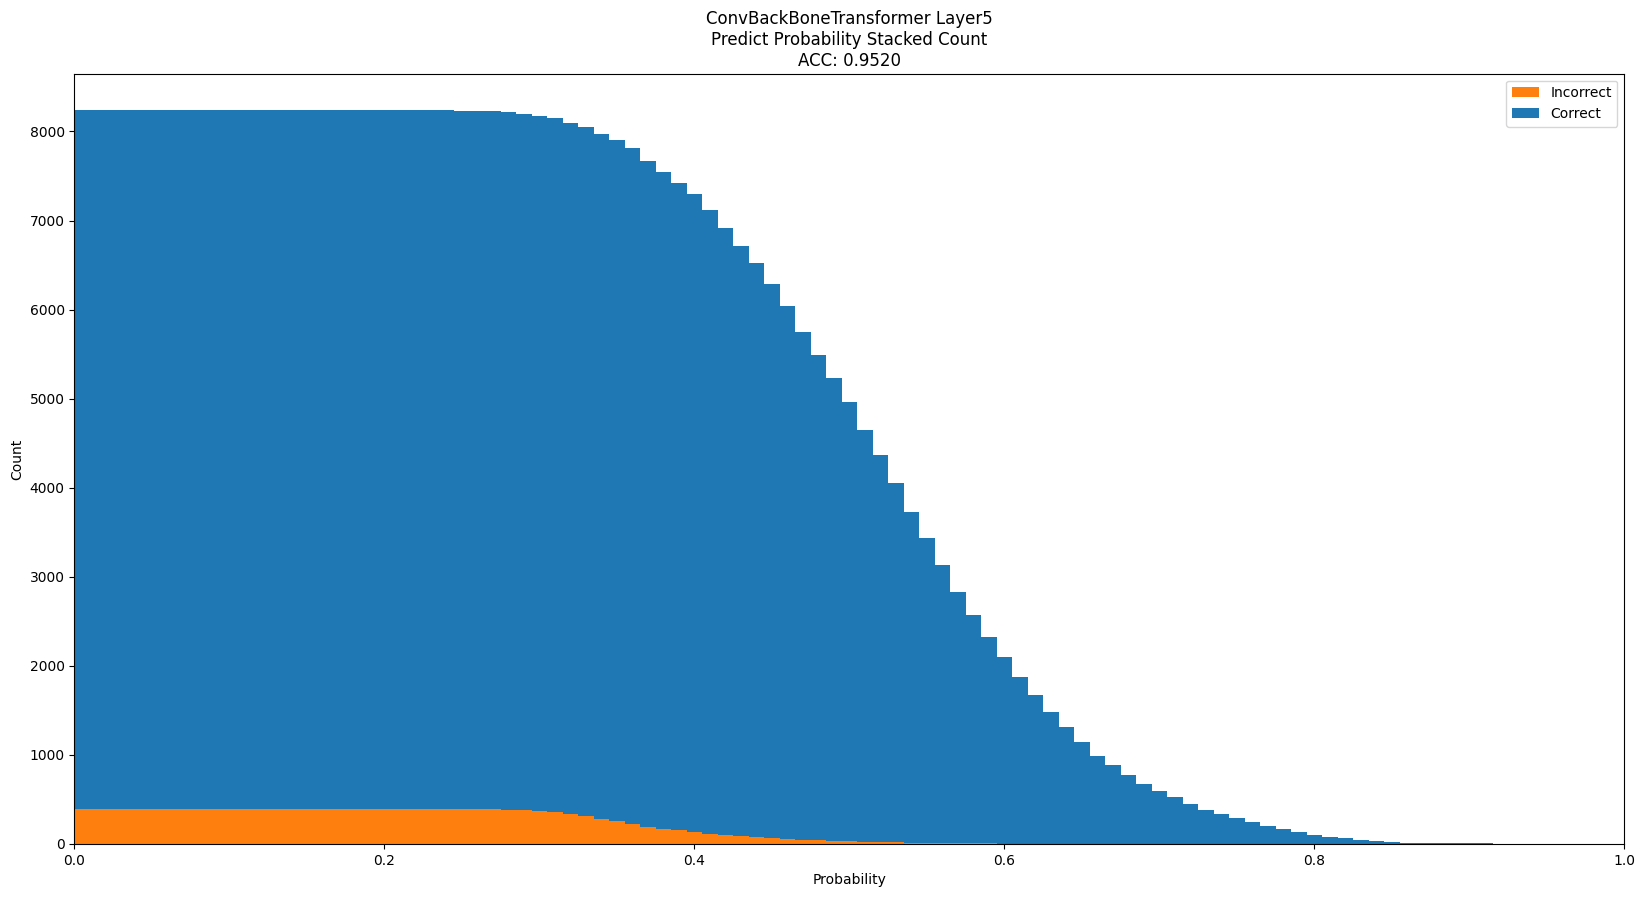

In [61]:
show_count_stacked(convbbt_layer5_df, 'ConvBackBoneTransformer Layer5')

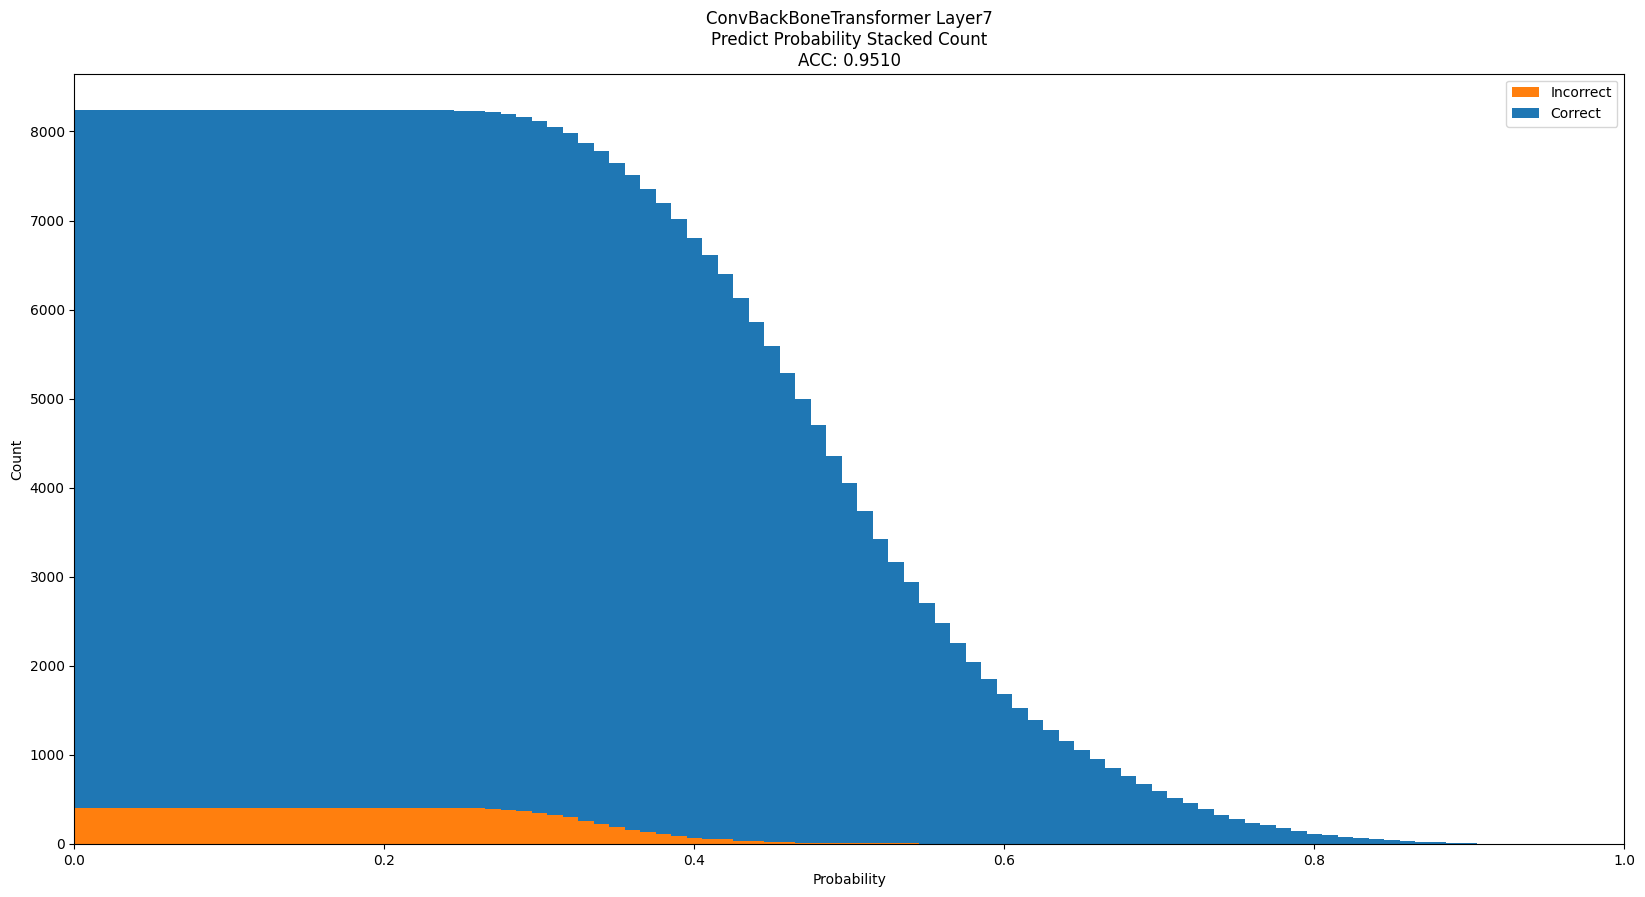

In [62]:
show_count_stacked(convbbt_layer7_df, 'ConvBackBoneTransformer Layer7')

# Each Model's Result Analysis

In [63]:
convbbt_layer3_correct_index = convbbt_layer3_df.loc[convbbt_layer3_df.true_label==convbbt_layer3_df.predict_label].index
convbbt_layer5_correct_index = convbbt_layer5_df.loc[convbbt_layer5_df.true_label==convbbt_layer5_df.predict_label].index
convbbt_layer7_correct_index = convbbt_layer7_df.loc[convbbt_layer7_df.true_label==convbbt_layer7_df.predict_label].index

convbbt_layer3_incorrect_index = convbbt_layer3_df.loc[convbbt_layer3_df.true_label!=convbbt_layer3_df.predict_label].index
convbbt_layer5_incorrect_index = convbbt_layer5_df.loc[convbbt_layer5_df.true_label!=convbbt_layer5_df.predict_label].index
convbbt_layer7_incorrect_index = convbbt_layer7_df.loc[convbbt_layer7_df.true_label!=convbbt_layer7_df.predict_label].index

all_correct_index = list(set(convbbt_layer3_correct_index)& set(convbbt_layer5_correct_index) & set(convbbt_layer7_correct_index))
all_incorrect_index = list(set(convbbt_layer3_incorrect_index) & set(convbbt_layer5_incorrect_index) & set(convbbt_layer7_incorrect_index))

print(f'All index num: {len(convbbt_layer3_df)}')
print(f'All correct index num: {len(all_correct_index)}')
print(f'All incorrect index num: {len(all_incorrect_index)}')
print(f'ideal accuracy: {1-len(all_incorrect_index)/len(convbbt_layer3_df):.4f}')
print("-"*50 )
print("All incorrect index label count:")
convbbt_layer3_df.loc[all_incorrect_index,"true_label"].value_counts()

All index num: 8237
All correct index num: 7580
All incorrect index num: 152
ideal accuracy: 0.9815
--------------------------------------------------
All incorrect index label count:


Upstairs      72
Downstairs    38
Walking       17
Jogging       14
Standing       6
Sitting        5
Name: true_label, dtype: int64

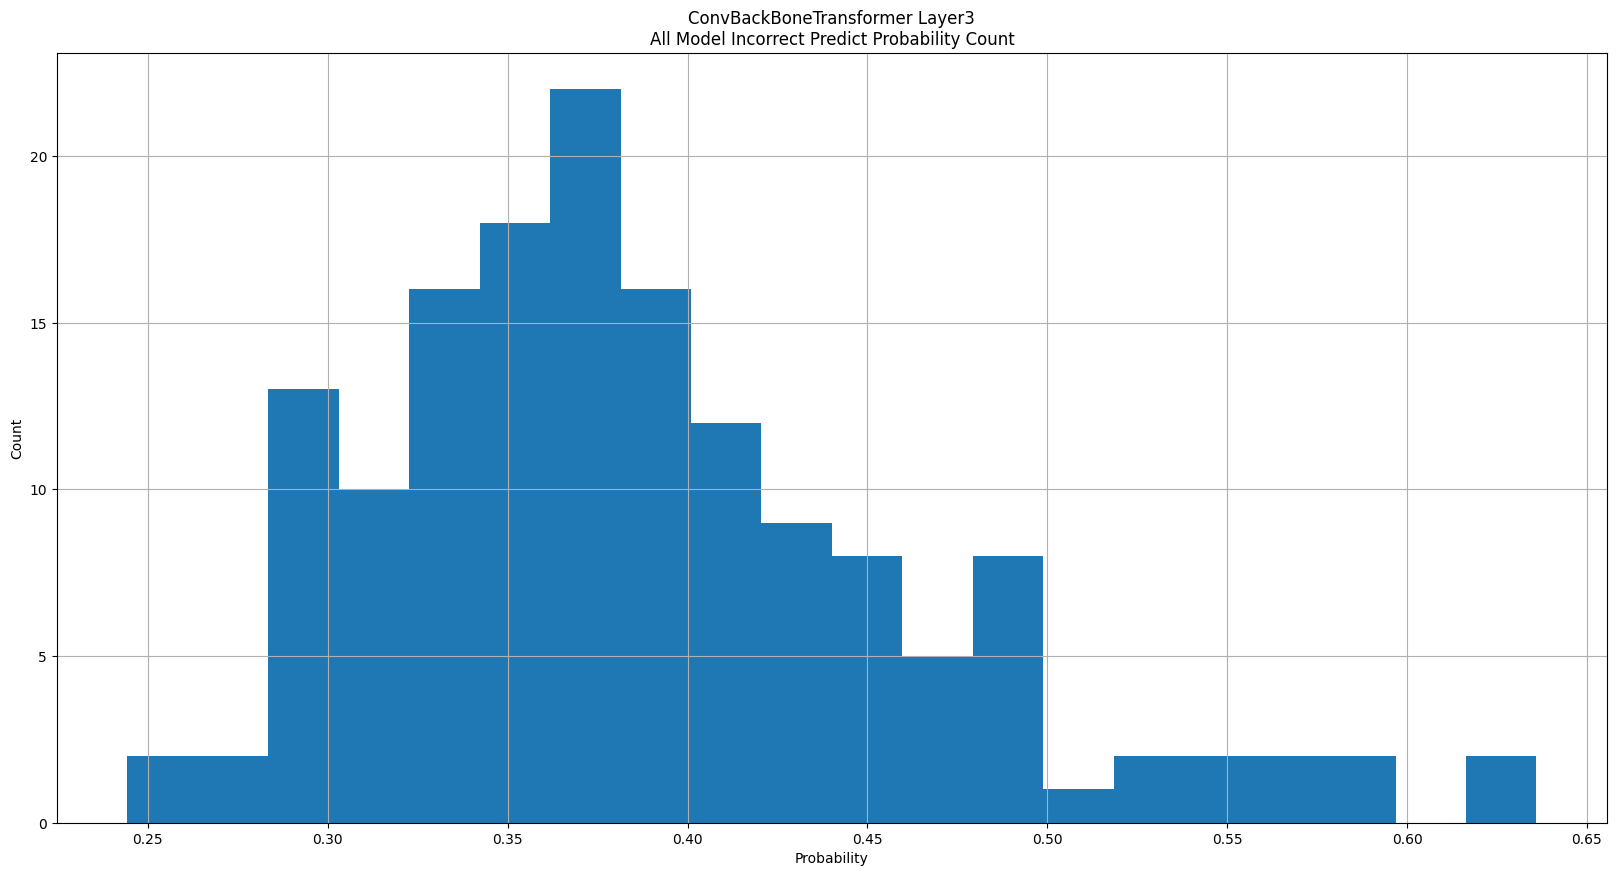

Upstairs      47
Walking       42
Downstairs    40
Jogging       19
Sitting        2
Standing       2
Name: predict_label, dtype: int64

In [64]:
convbbt_layer3_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('ConvBackBoneTransformer Layer3\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
convbbt_layer3_df.loc[all_incorrect_index,"predict_label"].value_counts()

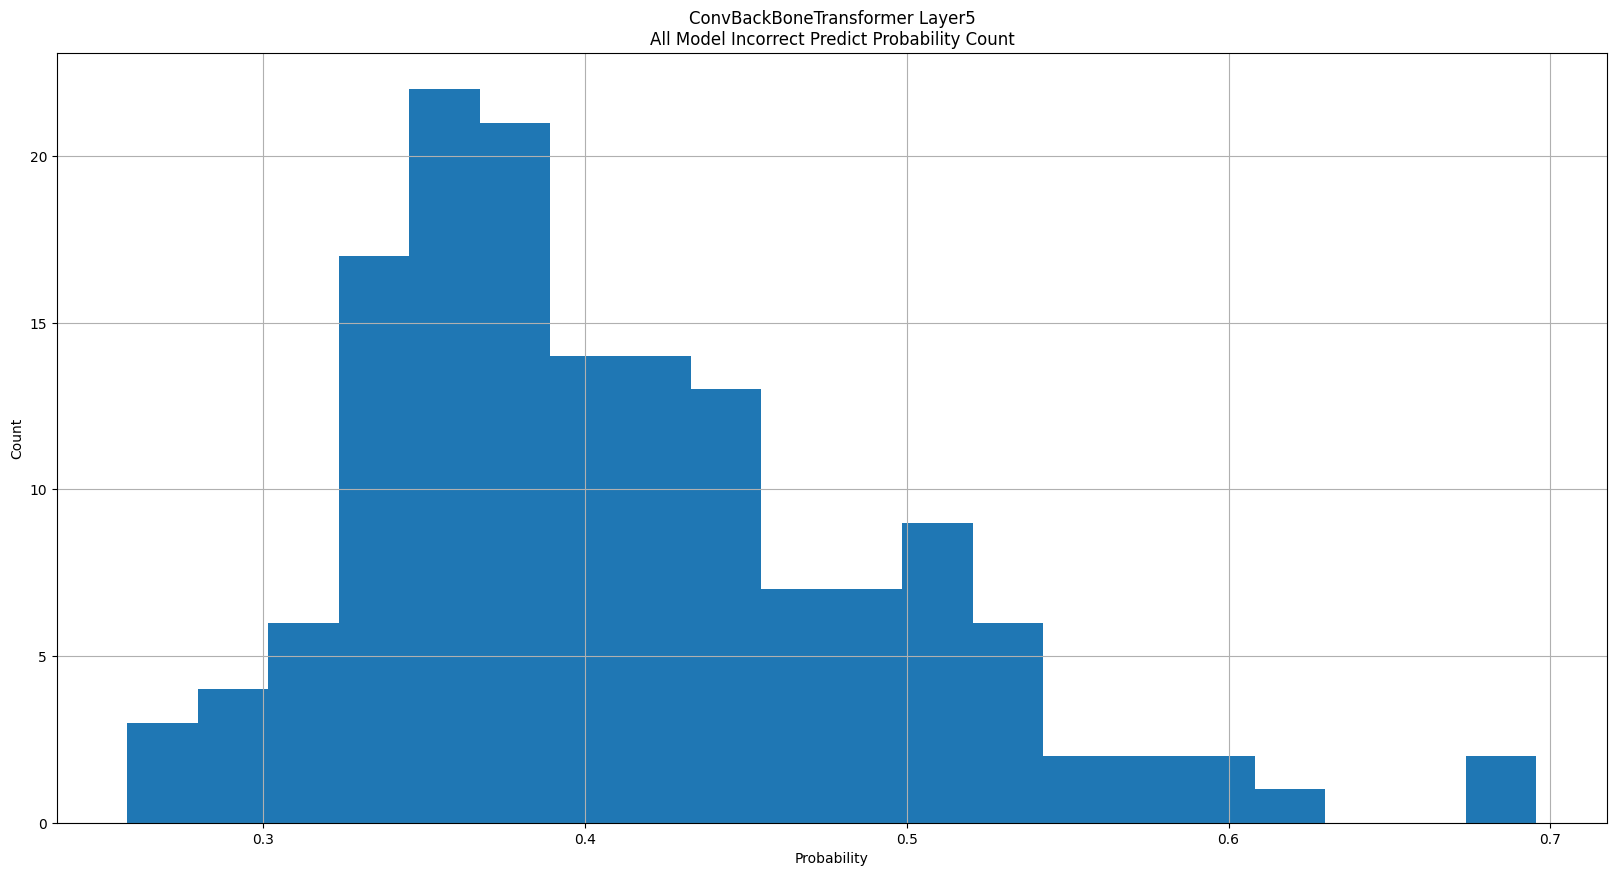

Upstairs      49
Downstairs    43
Walking       40
Jogging       18
Standing       2
Name: predict_label, dtype: int64

In [65]:
convbbt_layer5_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('ConvBackBoneTransformer Layer5\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
convbbt_layer5_df.loc[all_incorrect_index,"predict_label"].value_counts()

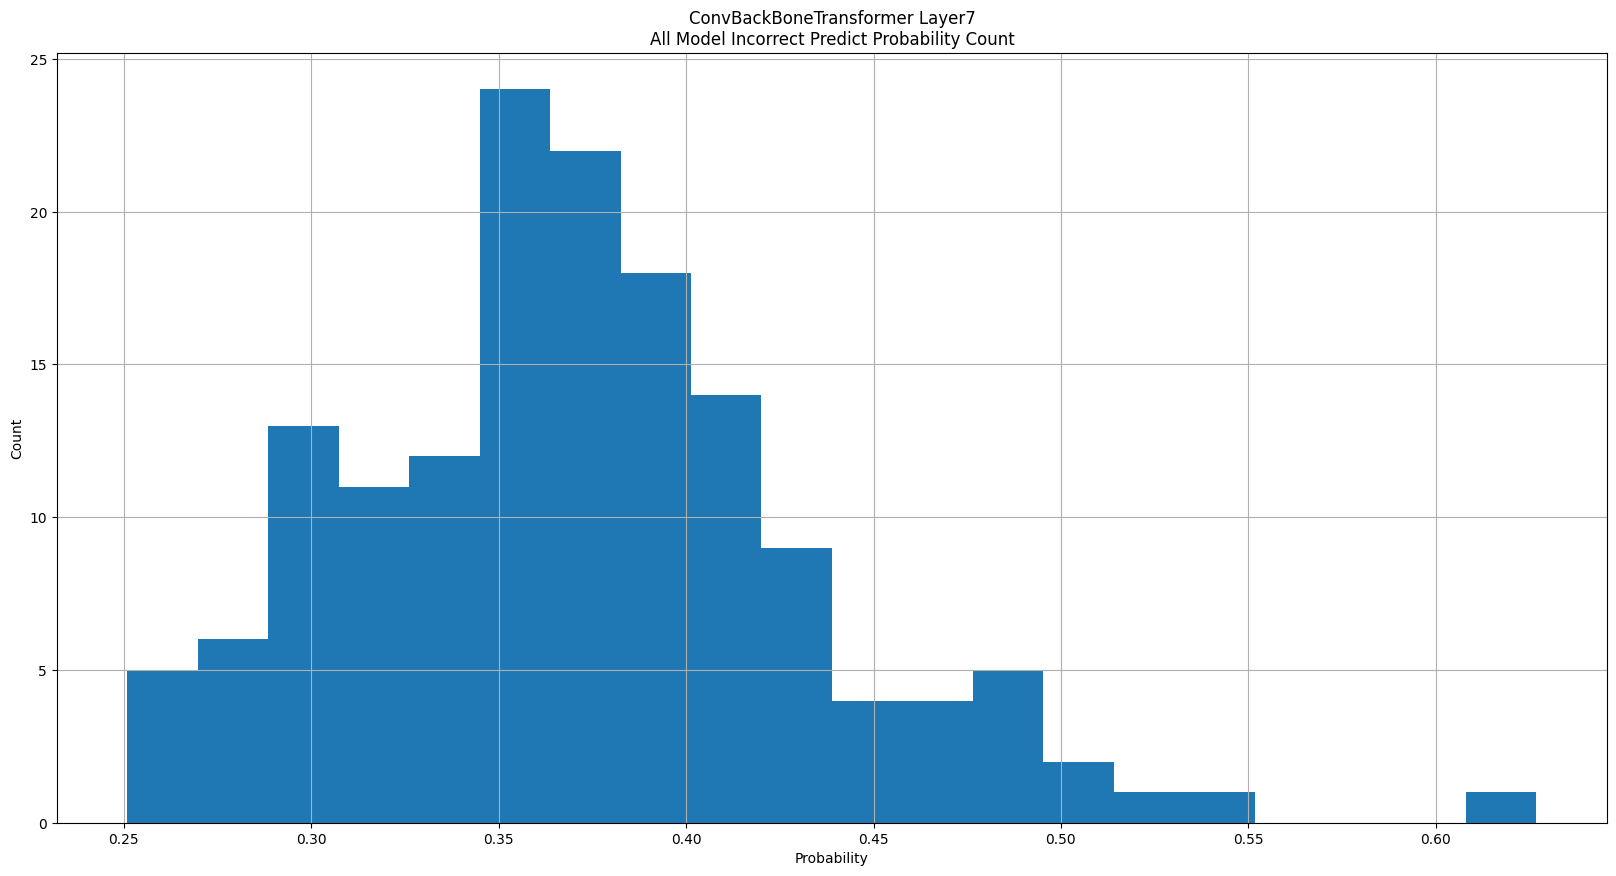

Upstairs      45
Walking       43
Downstairs    40
Jogging       21
Standing       3
Name: predict_label, dtype: int64

In [66]:
convbbt_layer7_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('ConvBackBoneTransformer Layer7\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
convbbt_layer7_df.loc[all_incorrect_index,"predict_label"].value_counts()

# Ensamble Model

## 1. Sum of Probabilities Ensamble

In [67]:
ensamble1_name = 'Sum-of-Probability-Ensamble'

In [68]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
ensamble1_df = convbbt_layer3_df.loc[:, LABELS].copy() + convbbt_layer5_df.loc[:, LABELS].copy() + convbbt_layer7_df.loc[:, LABELS].copy()
ensamble1_df = ensamble1_df.apply(lambda x: x / x.sum(), axis=1)
ensamble1_df["predict_probability"] = ensamble1_df.max(axis=1)
ensamble1_df["predict_label"] = ensamble1_df.idxmax(axis=1)
ensamble1_df['true_label'] = true_label.map(lambda x: LABELS[x])

In [69]:
ensamble1_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.305807,0.060132,0.000000,0.056989,0.225269,0.351802,0.351802,Walking,Walking
1,0.085055,0.000000,0.436851,0.214258,0.137294,0.126542,0.436851,Sitting,Sitting
2,0.249476,0.007686,0.033097,0.122715,0.347626,0.239400,0.347626,Upstairs,Upstairs
3,0.205330,0.602914,0.019700,0.038533,0.055707,0.077817,0.602914,Jogging,Jogging
4,0.063206,0.058604,0.143732,0.509584,0.034163,0.190711,0.509584,Standing,Standing


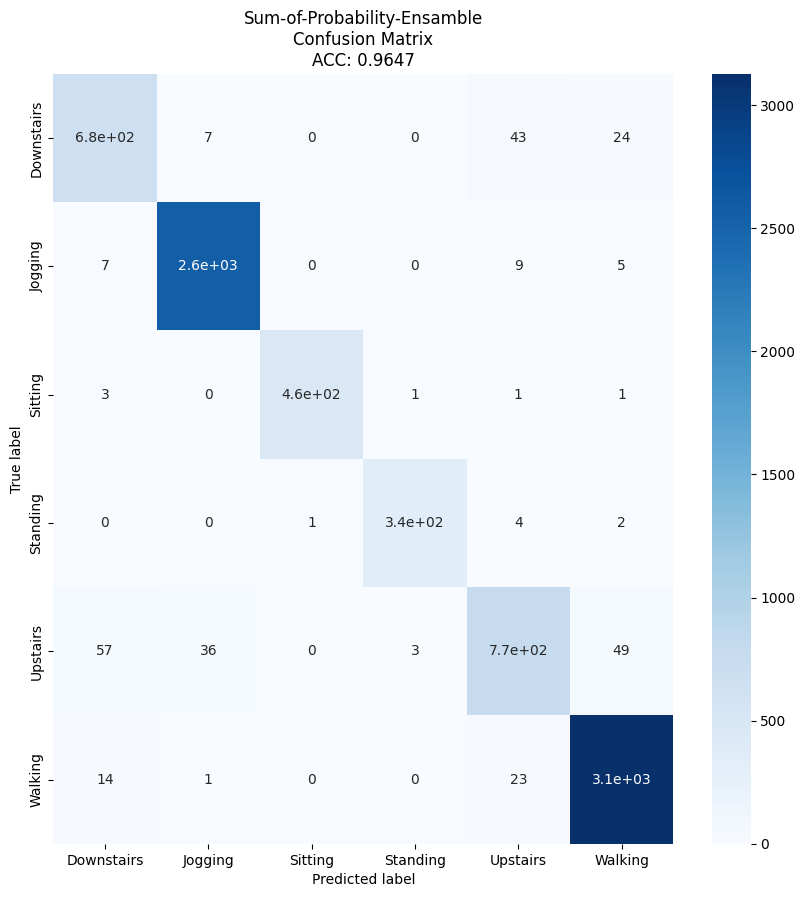

In [70]:
show_confusion_matrix(ensamble1_df, ensamble1_name)

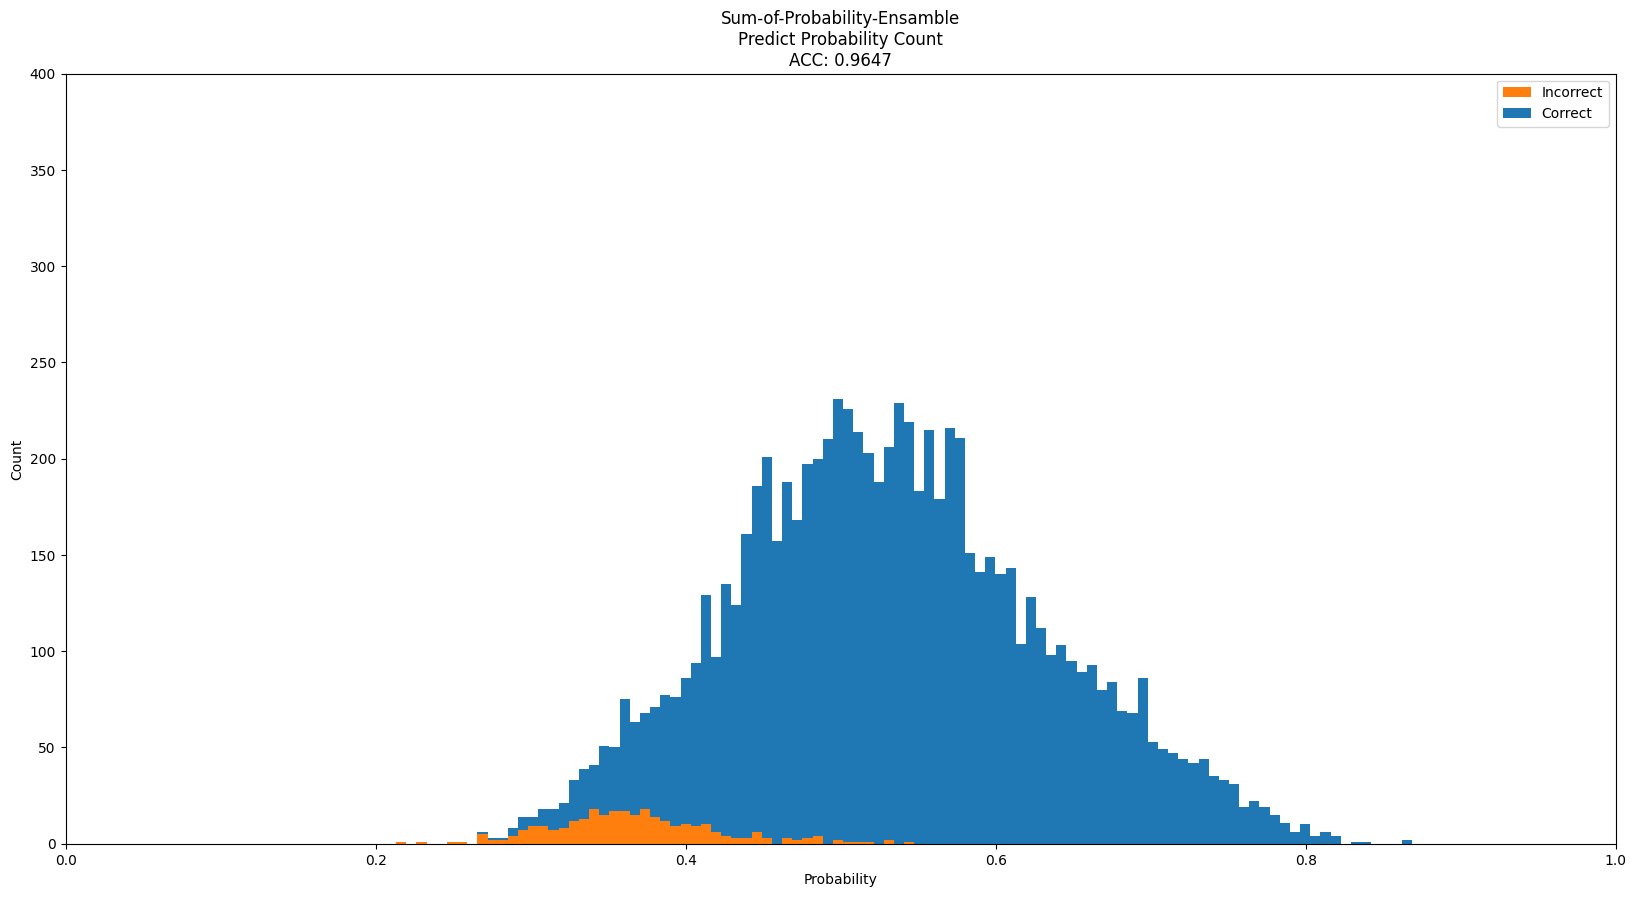

In [71]:
show_count(ensamble1_df, ensamble1_name)

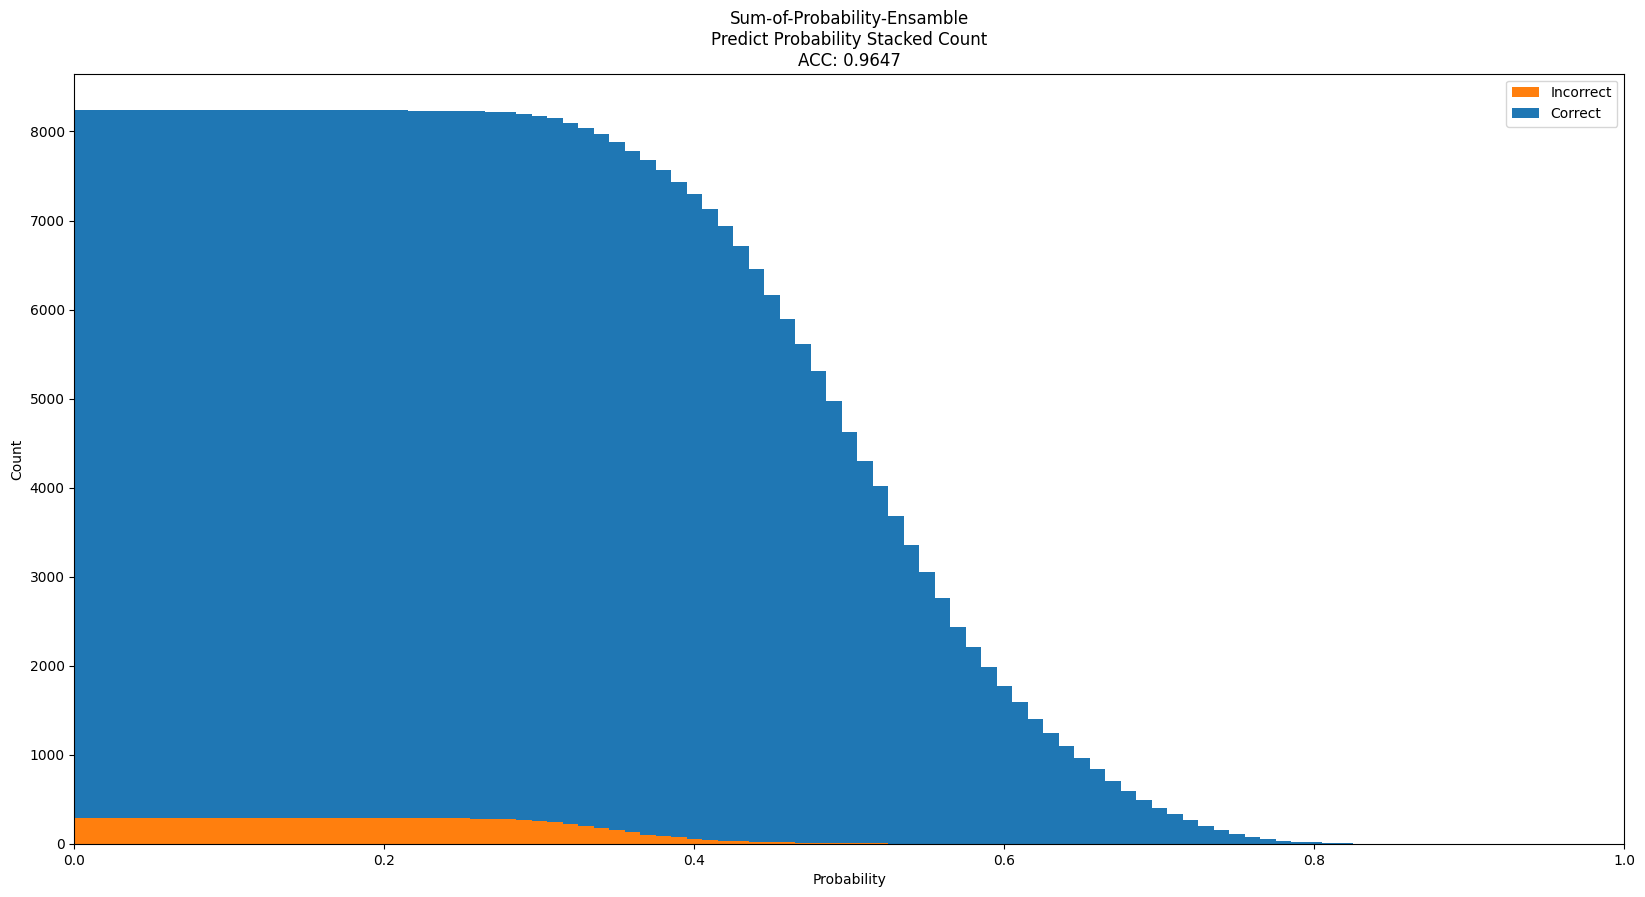

In [72]:
show_count_stacked(ensamble1_df, ensamble1_name)

In [73]:
print(f'Accuracy: {calc_accuracy(ensamble1_df):.4f}')
print(f'incorrect index num: {len(ensamble1_df.loc[ensamble1_df.true_label!=ensamble1_df.predict_label])}')
print("-"*50)
ensamble1_df.loc[ensamble1_df.predict_label!=ensamble1_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9647
incorrect index num: 291
--------------------------------------------------


Downstairs    81
Walking       81
Upstairs      80
Jogging       44
Standing       4
Sitting        1
Name: predict_label, dtype: int64

In [74]:
calc_thredshold_df(ensamble1_df)

/tmp/ipykernel_29736/167466859.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.964672,8237
0.1,0.964672,8237
0.2,0.964672,8237
0.3,0.967785,8195
0.4,0.990588,7437
0.5,0.998592,4971
0.6,1.000000,1982
0.7,1.000000,487
0.8,1.000000,21


## 2. Vote Ensamble

In [75]:
ensamble2_name = 'Vote-Ensamble'

In [76]:
modelnames = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
ensamble2_label_df = pd.concat([convbbt_layer3_df.loc[:, "predict_label"].copy(), convbbt_layer5_df.loc[:, "predict_label"].copy(), convbbt_layer7_df.loc[:, "predict_label"].copy()], axis=1)
ensamble2_probability_df= pd.concat([convbbt_layer3_df.loc[:, "predict_probability"].copy(), convbbt_layer5_df.loc[:, "predict_probability"].copy(), convbbt_layer7_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble2_label_df.columns = modelnames
ensamble2_probability_df.columns = modelnames
ensamble2_df = pd.DataFrame({
                        "predict_label": ensamble2_label_df.apply(lambda x: x.value_counts().idxmax(), axis=1),
                        "predict_probability": ensamble2_probability_df.max(axis=1),
                        "true_label": true_label.map(lambda x: LABELS[x]), "predict_probability": ensamble2_probability_df.max(axis=1),
                        })

In [77]:
ensamble2_df.head()

,predict_label,predict_probability,true_label
0,Walking,0.404205,Walking
1,Sitting,0.490490,Sitting
2,Upstairs,0.351279,Upstairs
3,Jogging,0.647780,Jogging
4,Standing,0.643581,Standing


In [78]:
value_counts = ensamble2_label_df.apply(lambda x: x.value_counts(), axis=1)

vote_3_index = value_counts.loc[(value_counts == 3).apply(lambda x: any(x), axis=1),:].index
vote_2_index = value_counts.loc[(value_counts == 2).apply(lambda x: any(x), axis=1),:].index
vote_1_index = list(set(value_counts.loc[(value_counts == 1).apply(lambda x: any(x), axis=1),:].index) - set(vote_2_index))

vote_3 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_3_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_3_index].map(lambda x: LABELS[x])
                })
vote_2 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_2_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_2_index].map(lambda x: LABELS[x])
                })
vote_1 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_1_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_1_index].map(lambda x: LABELS[x])
                })

In [79]:
print('All num: ', len(ensamble2_label_df))
print(f'Vote 3 num: {len(vote_3)}') 
print(f'Vote 2 num: {len(vote_2)}')
print(f'Vote 1 num: {len(vote_1)}')

All num:  8237
Vote 3 num: 7689
Vote 2 num: 515
Vote 1 num: 33


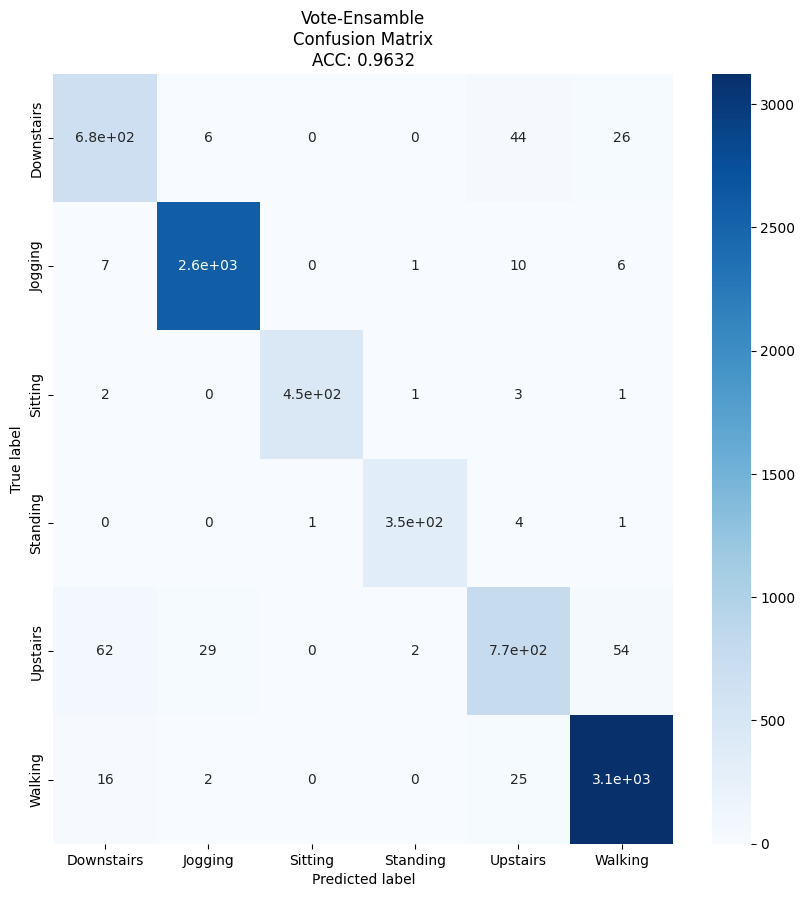

In [80]:
show_confusion_matrix(ensamble2_df, ensamble2_name)

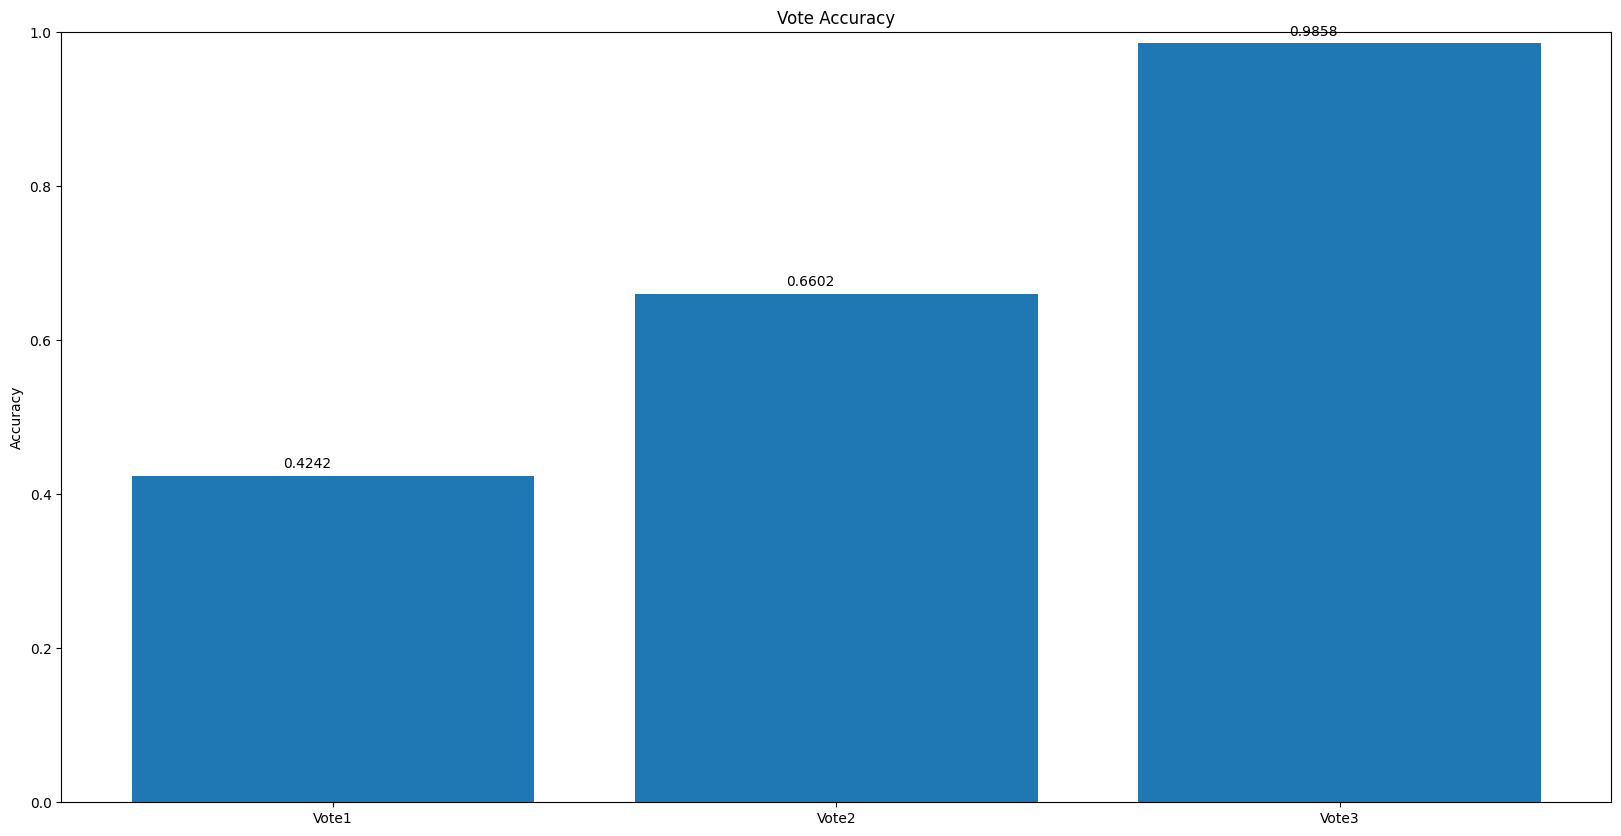

In [81]:
vote1_acc = calc_accuracy(vote_1)
vote2_acc = calc_accuracy(vote_2)
vote3_acc = calc_accuracy(vote_3)
plt.bar(["Vote1", "Vote2", "Vote3"], [vote1_acc, vote2_acc, vote3_acc])
plt.text(-0.1, vote1_acc+0.01, f'{vote1_acc:.4f}')
plt.text(0.9, vote2_acc+0.01, f'{vote2_acc:.4f}')
plt.text(1.9, vote3_acc+0.01, f'{vote3_acc:.4f}')
plt.title('Vote Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(f'assets/{ensamble2_name}-accuracy.png')
plt.show()

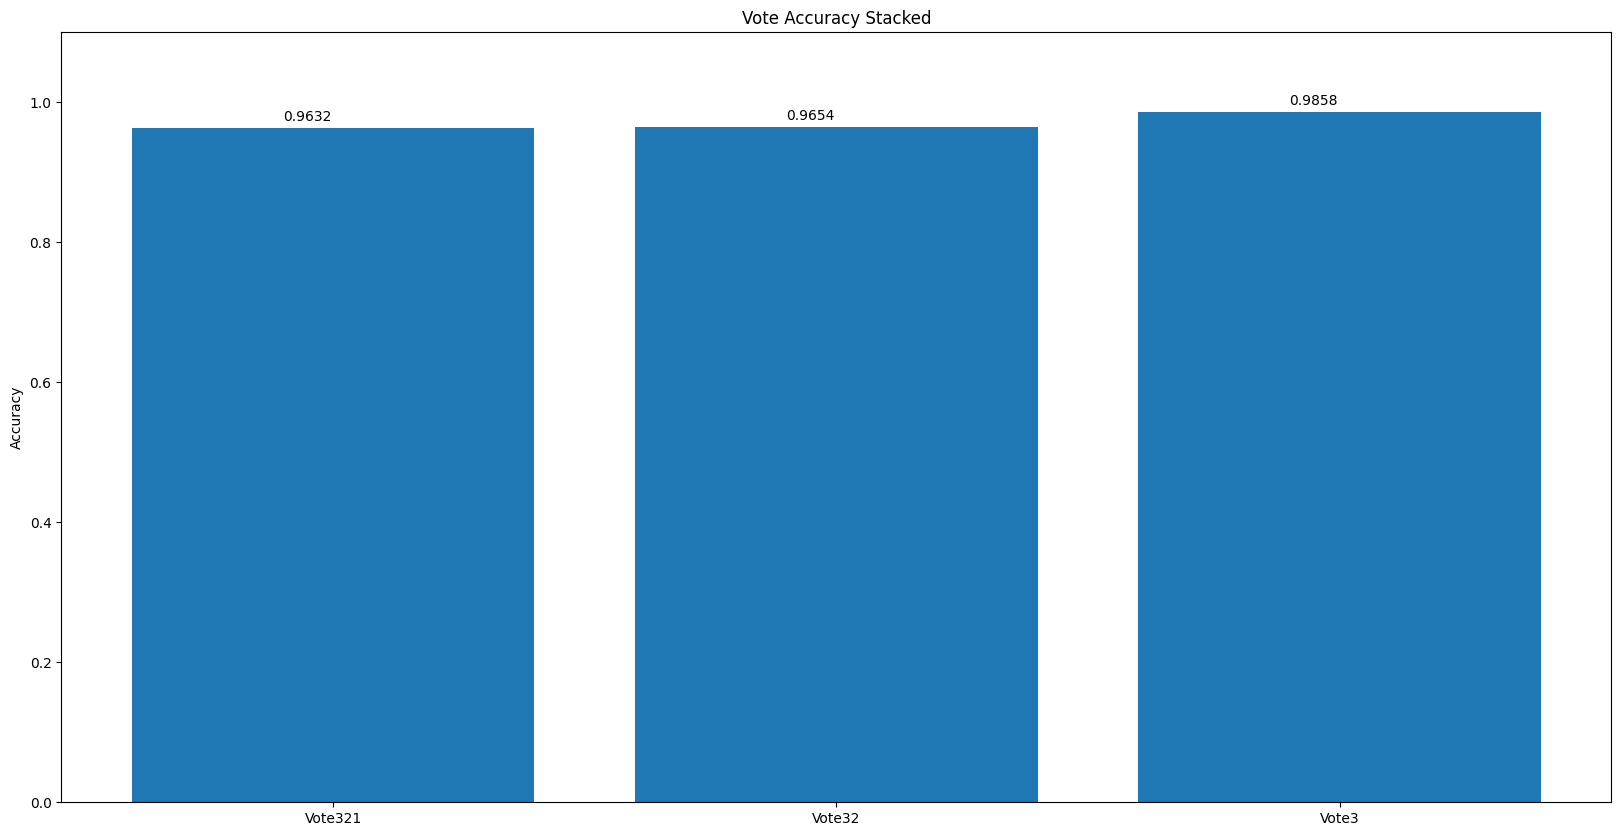

In [82]:
vote_321 = pd.concat([vote_3, vote_2, vote_1], axis=0).reset_index()
vote_32 = pd.concat([vote_3, vote_2], axis=0).reset_index()

vote_321_acc = calc_accuracy(vote_321)
vote_32_acc = calc_accuracy(vote_32)
plt.bar(["Vote321", "Vote32", "Vote3"], [vote_321_acc, vote_32_acc, vote3_acc])
plt.text(-0.1, vote_321_acc+0.01, f'{vote_321_acc:.4f}')
plt.text(0.9, vote_32_acc+0.01, f'{vote_32_acc:.4f}')
plt.text(1.9, vote3_acc+0.01, f'{vote3_acc:.4f}')
plt.title('Vote Accuracy Stacked')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.savefig(f'assets/{ensamble2_name}-accuracy-stacked.png')
plt.show()


In [83]:
print(f'Accuracy: {calc_accuracy(ensamble2_df):.4f}')
print(f'incorrect index num: {len(ensamble2_df.loc[ensamble2_df.true_label!=ensamble2_df.predict_label])}')
print("-"*50)
ensamble2_df.loc[ensamble2_df.predict_label!=ensamble2_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9632
incorrect index num: 303
--------------------------------------------------


Walking       88
Downstairs    87
Upstairs      86
Jogging       37
Standing       4
Sitting        1
Name: predict_label, dtype: int64

## 3. Max of Probability Ensamble

In [84]:
ensamble3_name = 'Max-of-Probability-Ensamble'

In [85]:
modelnames = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
ensamble3_label_df = pd.concat([convbbt_layer3_df.loc[:, "predict_label"].copy(), convbbt_layer5_df.loc[:, "predict_label"].copy(), convbbt_layer7_df.loc[:, "predict_label"].copy()], axis=1)
ensamble3_probability_df= pd.concat([convbbt_layer3_df.loc[:, "predict_probability"].copy(), convbbt_layer5_df.loc[:, "predict_probability"].copy(), convbbt_layer7_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble3_label_df.columns = modelnames
ensamble3_probability_df.columns = modelnames
ensamble3_df = pd.DataFrame({
                        "predict_label": ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1),
                        "predict_probability": ensamble3_probability_df.max(axis=1),
                        "predict_from": ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1),
                        "true_label": true_label.map(lambda x: LABELS[x]),
                        })
refcol = ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1)
for i in range(len(ensamble3_probability_df)):
    ensamble3_df.loc[i,"predict_label"] = ensamble3_label_df.loc[i, refcol.iloc[i]]

In [86]:
ensamble3_df.head()

,predict_label,predict_probability,predict_from,true_label
0,Walking,0.404205,ConvBackBoneTransformer Layer7,Walking
1,Sitting,0.490490,ConvBackBoneTransformer Layer5,Sitting
2,Upstairs,0.351279,ConvBackBoneTransformer Layer7,Upstairs
3,Jogging,0.647780,ConvBackBoneTransformer Layer7,Jogging
4,Standing,0.643581,ConvBackBoneTransformer Layer5,Standing


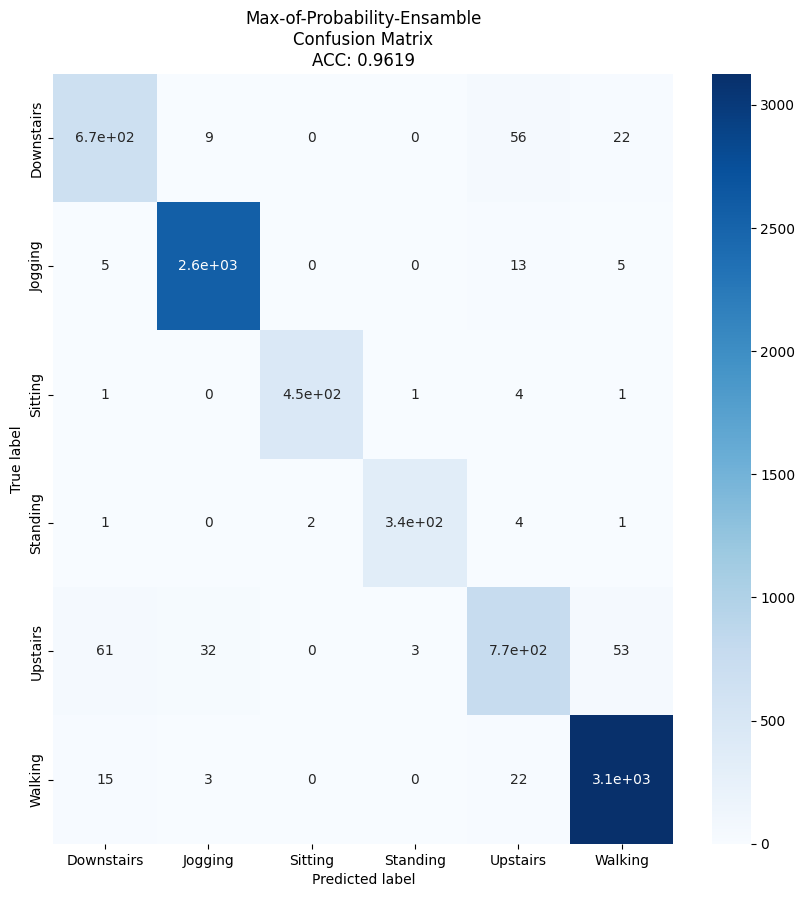

In [87]:
show_confusion_matrix(ensamble3_df, ensamble3_name)

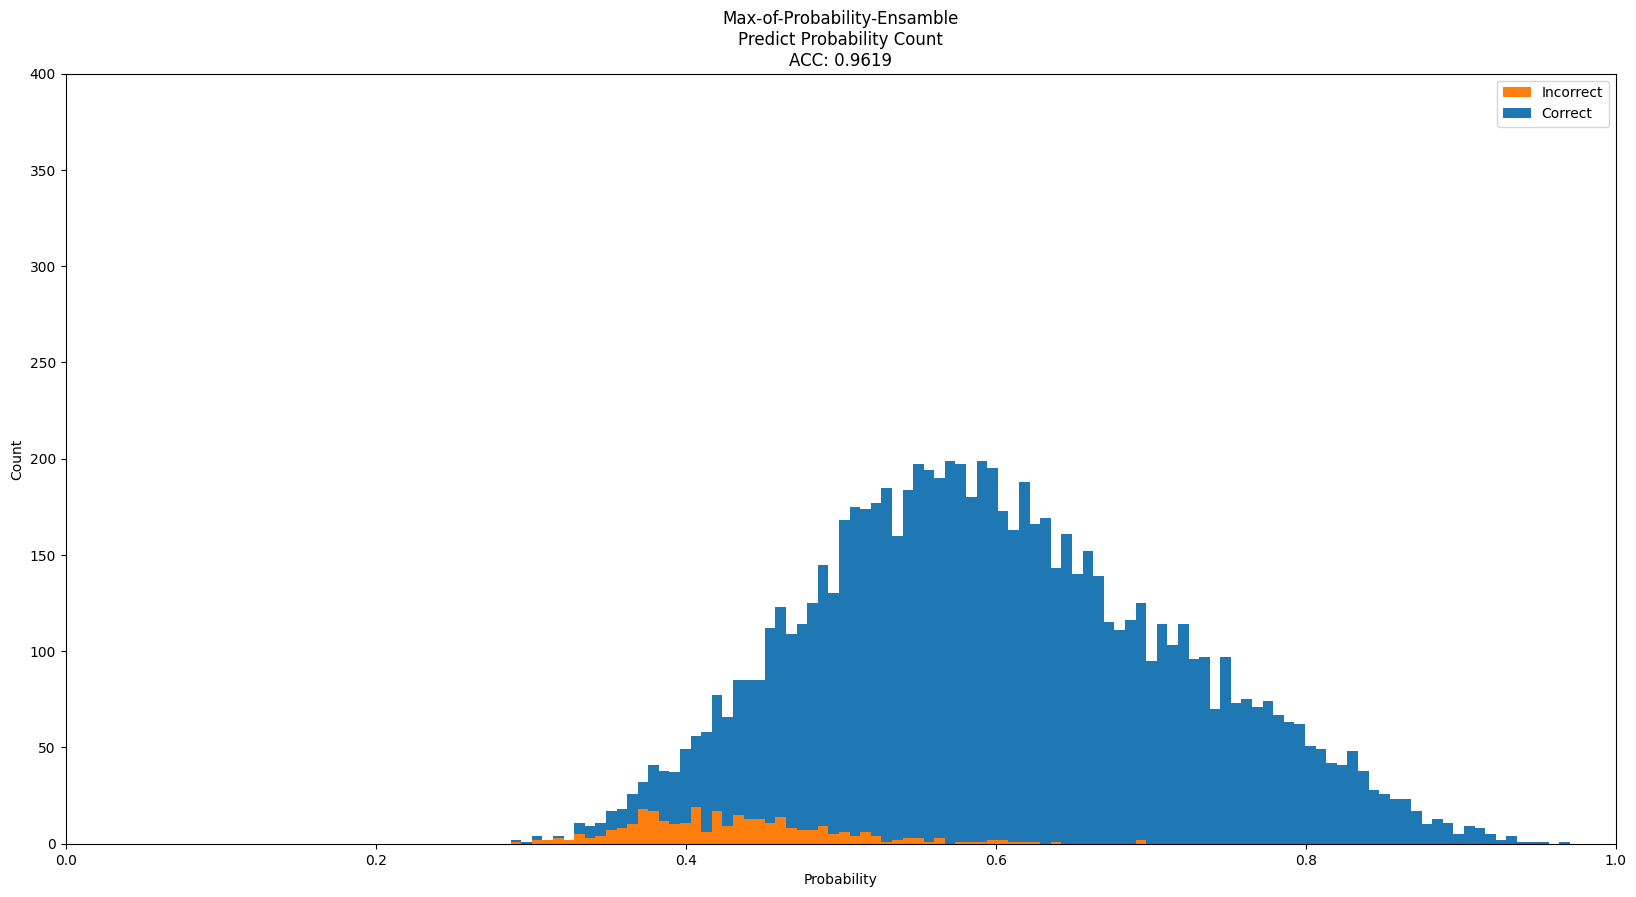

In [88]:
show_count(ensamble3_df, ensamble3_name)

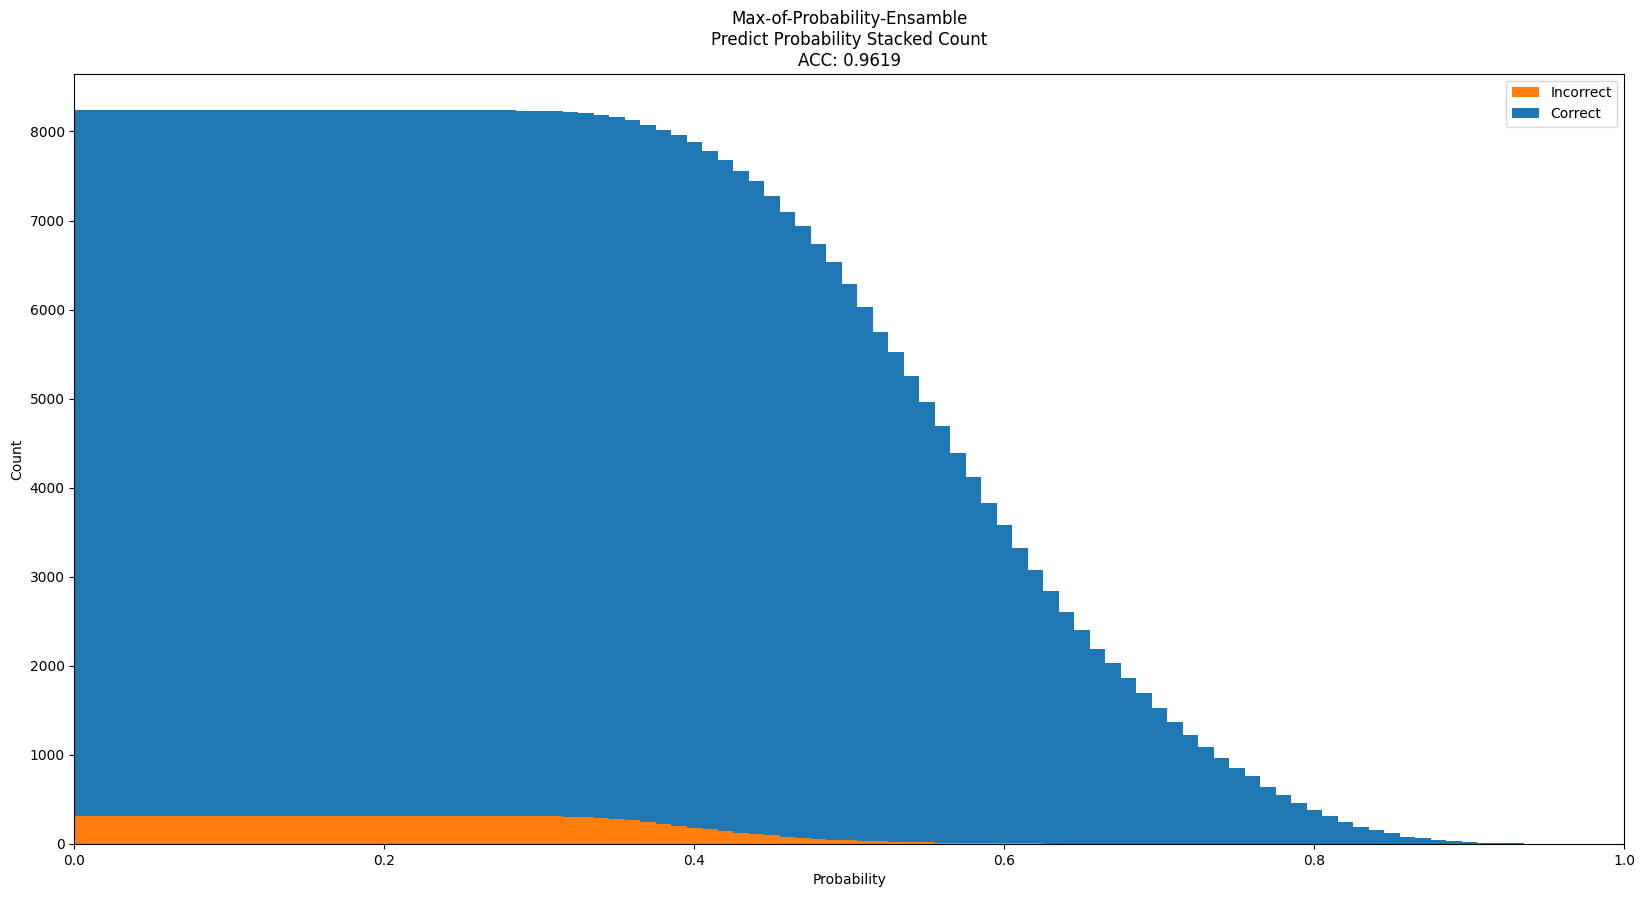

In [89]:
show_count_stacked(ensamble3_df, ensamble3_name)

In [90]:
print(f'Accuracy: {calc_accuracy(ensamble3_df):.4f}')
print(f'incorrect index num: {len(ensamble3_df.loc[ensamble3_df.true_label!=ensamble3_df.predict_label])}')
print("-"*50)
ensamble3_df.loc[ensamble3_df.predict_label!=ensamble3_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9619
incorrect index num: 314
--------------------------------------------------


Upstairs      99
Downstairs    83
Walking       82
Jogging       44
Standing       4
Sitting        2
Name: predict_label, dtype: int64

In [91]:
calc_thredshold_df(ensamble3_df)

/tmp/ipykernel_29736/167466859.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.961879,8237
0.1,0.961879,8237
0.2,0.961879,8237
0.3,0.961991,8235
0.4,0.974610,7956
0.5,0.992965,6539
0.6,0.997646,3823
0.7,1.000000,1690
0.8,1.000000,455
